# Vaccines and patient characteristics

### Import libraries and data

The datasets used for this report are created using the study definition [`/analysis/study_definition.py`](../analysis/study_definition.py), using codelists referenced in [`/codelists/codelists.txt`](../codelists/codelists.txt). 

In [1]:
%load_ext autoreload
%autoreload 2
 
import pandas as pd
import numpy as np
import subprocess
from IPython.display import display, Markdown, HTML

suffix = "_tpp"

# get current branch
current_branch = subprocess.run(["git", "rev-parse", "--abbrev-ref", "HEAD"], capture_output=True).stdout.decode("utf8").strip()

### Import our custom functions

In [2]:
# import custom functions from 'lib' folder
import sys
sys.path.append('../lib/')

In [3]:
from data_processing import load_data

In [4]:
from report_results import find_and_save_latest_date, create_output_dirs

In [5]:
# create output directories to save files into 
savepath, savepath_figure_csvs, savepath_table_csvs = create_output_dirs()

### Load and Process the raw data 

In [6]:
df = load_data()

In [7]:
latest_date, formatted_latest_date = find_and_save_latest_date(df, savepath=savepath)

In [8]:
print(f"Latest Date: {formatted_latest_date}")

Latest Date: 30 Mar 2021


### Summarise by group and demographics at latest date

#### Calculate cumulative sums at each date and select latest date + previous figures for comparison

In [9]:
from report_results import cumulative_sums

In [10]:
# population subgroups - in a dict to indicate which field to filter on


population_subgroups = {"80+":1,
        "70-79":2, 
        "care home":3, 
        "shielding (aged 16-69)":4, 
        "65-69": 5,  
        "LD (aged 16-64)": 6,  
        "60-64": 7,
        "55-59": 8,
        "50-54": 9,
        "16-49, not in other eligible groups shown":0 
        # NB the key for the final group (0) must contain phrase "not in other eligible groups"
        }

groups = population_subgroups.keys()


#  list demographic/clinical factors to include for given group
DEFAULT = ["sex","ageband_5yr","ethnicity_6_groups","ethnicity_16_groups", "imd_categories", 
                              "bmi", "chronic_cardiac_disease", "current_copd", "dialysis", "dmards", "dementia",
                              "psychosis_schiz_bipolar","LD","ssri",
                              "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"]
#for specific age bands remove features which are included elsehwere or not prevalent
o65 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis")]
o60 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD")]
o50 = [d for d in DEFAULT if d not in ("ageband_5yr", "dialysis", "LD", "dementia",
                                       "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"
                                      )]
other = ["sex","ageband", "ethnicity_6_groups", "ethnicity_16_groups","imd_categories",
                              "bmi","chronic_cardiac_disease", "current_copd", "dmards","ssri"]

# dictionary mapping population subgroups to a list of demographic/clinical factors to include for that group
features_dict = {0:    other, ## patients not assigned to a priority group
                 "care home": ["sex", "ageband_5yr", "ethnicity_6_groups", "dementia"],
                 "shielding (aged 16-69)": ["newly_shielded_since_feb_15", "sex", "ageband", "ethnicity_6_groups", "imd_categories",
                                           "LD"],
                 "65-69":    o65,
                 "60-64":    o60,
                 "55-59":    o50,
                 "50-54":    o50,
                 "LD (aged 16-64)":  ["sex", "ageband_5yr", "ethnicity_6_groups"],
                 "DEFAULT":   DEFAULT # other age groups
                }


In [11]:
df_dict_cum = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=features_dict, latest_date=latest_date)

In [12]:
# for details on second doses, no need for breakdowns of any groups (only "overall" figures will be included)
second_dose_features = {}
for g in groups:
    second_dose_features[g] = []

df_dict_cum_second_dose = cumulative_sums(df, groups_of_interest=population_subgroups, features_dict=second_dose_features, 
                                          latest_date=latest_date, reference_column_name="covid_vacc_second_dose_date")

### Cumulative vaccination figures - overall

In [13]:
from report_results import make_vaccine_graphs

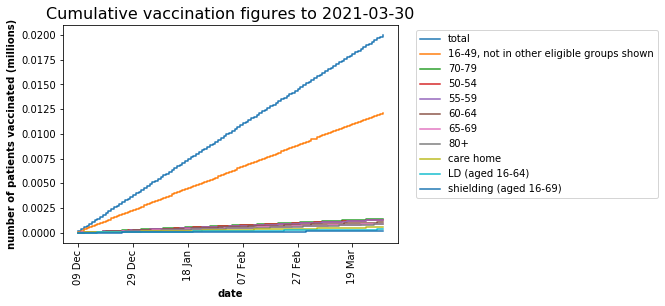

In [14]:
make_vaccine_graphs(df, latest_date=latest_date, savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)

### Reports 

In [15]:
from report_results import summarise_data_by_group

In [16]:
summarised_data_dict = summarise_data_by_group(df_dict_cum, latest_date=latest_date, groups=groups)

In [17]:
summarised_data_dict_2nd_dose = summarise_data_by_group(df_dict_cum_second_dose, latest_date=latest_date, groups=groups)

### Proportion of each eligible population vaccinated to date

In [18]:
from report_results import create_summary_stats, create_detailed_summary_uptake

In [19]:
summ_stat_results, additional_stats = create_summary_stats(df, summarised_data_dict, formatted_latest_date, groups=groups, 
                                         savepath=savepath, suffix=suffix)

In [20]:
summ_stat_results_2nd_dose, _ = create_summary_stats(df, summarised_data_dict_2nd_dose, formatted_latest_date, 
                                                  groups=groups, savepath=savepath, 
                                                  vaccine_type="second_dose", suffix=suffix)

In [21]:
# display the results of the summary stats on first and second doses
display(pd.DataFrame(summ_stat_results).join(pd.DataFrame(summ_stat_results_2nd_dose)))    
display(Markdown(f"*\n figures rounded to nearest 7"))

,first dose as at 30 Mar 2021,second dose as at 30 Mar 2021
Total vaccinated in TPP,"19,999","4,998"
80+,"40.1% (854 of 2,121)","10.1% (217 of 2,121)"
70-79,"39.5% (1,414 of 3,570)","9.6% (343 of 3,570)"
care home,"40.0% (546 of 1,372)","10.6% (147 of 1,372)"
shielding (aged 16-69),37.0% (154 of 413),10.2% (42 of 413)
65-69,"41.1% (903 of 2,191)","9.6% (210 of 2,191)"
LD (aged 16-64),41.3% (322 of 784),10.3% (84 of 784)
60-64,"39.7% (1,043 of 2,632)","11.2% (294 of 2,632)"
55-59,"41.5% (1,302 of 3,136)","10.0% (315 of 3,136)"
50-54,"38.3% (1,309 of 3,409)","9.7% (329 of 3,409)"


*
 figures rounded to nearest 7

In [22]:
# other information on vaccines

for x in additional_stats.keys():
    display(Markdown(f"{x}: {additional_stats[x]}"))
    
display(Markdown(f"*\n figures rounded to nearest 7"))

Second doses (% of all vaccinated): **25.0%** (4,998)

Oxford-AZ vaccines (% of all first doses): **0.0%** (0)

Moderna vaccines (% of all first doses): **0.0%** (7)

*
 figures rounded to nearest 7

# Detailed summary of coverage among population groups as at latest date

In [23]:
create_detailed_summary_uptake(summarised_data_dict, formatted_latest_date, 
                               groups=population_subgroups.keys(),
                               savepath=savepath)

## 

## COVID vaccination rollout among **80+** population up to 30 Mar 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     851   
sex                       F                                           455   
                          M                                           399   
ageband_5yr               0                                            56   
                          0-15                                         56   
                          16-29                                        56   
                          30-34                                        49   
                          35-39                                        35   
                          40-44                                        42   
                          45-49                                        56   
                          50-54                                        56   
                          55-59                                        49   
                          60-64                                        49   
                          65-69                                        70   
                          70-74                                        63   
                          75-79                                        56   
                          80-84                                        56   
                          85-89                                        49   
                          90+                                          63   
ethnicity_6_groups        Black                                       140   
                          Mixed                                       140   
                          Other                                       140   
                          South Asian                                 161   
                          Unknown                                     119   
                          White                                       147   
ethnicity_16_groups        African                                     56   
                           Bangladeshi or British Bangladeshi          42   
                           Caribbean                                   42   
                           Chinese                                     42   
                           Other                                       49   
                           Other Asian                                 49   
                          British or Mixed British                     49   
                          Indian or British Indian                     49   
                          Irish                                        35   
                          Other Black                                  56   
                          Other White                                  56   
                          Other mixed                                  42   
                          Pakistani or British Pakistani               35   
                          Unknown                                     119   
                          White + Asian                                42   
                          White + Black African                        56   
                          White + Black Caribbean                      42   
imd_categories            1 Most deprived                             168   
                          2                                           168   
                          3                                           175   
                          4                                           168   
                          5 Least deprived                            147   
                          Unknown                                      28   
bmi                       30+                                         259   
                          under 30                                    595   
chronic_cardiac_disease   no                               

## 

## COVID vaccination rollout among **70-79** population up to 30 Mar 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1411   
sex                       F                                           714   
                          M                                           693   
ageband_5yr               0                                            84   
                          0-15                                         91   
                          16-29                                        77   
                          30-34                                        91   
                          35-39                                        84   
                          40-44                                       105   
                          45-49                                        70   
                          50-54                                        98   
                          55-59                                        84   
                          60-64                                        91   
                          65-69                                        91   
                          70-74                                        84   
                          75-79                                        91   
                          80-84                                        84   
                          85-89                                        98   
                          90+                                          77   
ethnicity_6_groups        Black                                       224   
                          Mixed                                       231   
                          Other                                       245   
                          South Asian                                 252   
                          Unknown                                     217   
                          White                                       245   
ethnicity_16_groups        African                                     63   
                           Bangladeshi or British Bangladeshi          70   
                           Caribbean                                   77   
                           Chinese                                     70   
                           Other                                       77   
                           Other Asian                                 77   
                          British or Mixed British                     91   
                          Indian or British Indian                     84   
                          Irish                                        70   
                          Other Black                                  63   
                          Other White                                  84   
                          Other mixed                                  70   
                          Pakistani or British Pakistani               77   
                          Unknown                                     210   
                          White + Asian                                84   
                          White + Black African                        70   
                          White + Black Caribbean                      84   
imd_categories            1 Most deprived                             259   
                          2                                           245   
                          3                                           266   
                          4                                           287   
                          5 Least deprived                            280   
                          Unknown                                      77   
bmi                       30+                                         434   
                          under 30                                    973   
chronic_cardiac_disease   no                               

## 

## COVID vaccination rollout among **care home** population up to 30 Mar 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             549     40.0   1372   
sex                F                   266     37.6    707   
                   M                   280     42.1    665   
ageband_5yr        0                    42     46.2     91   
                   0-15                 28     36.4     77   
                   16-29                42     50.0     84   
                   30-34                28     36.4     77   
                   35-39                42     42.9     98   
                   40-44                21     27.3     77   
                   45-49                35     41.7     84   
                   50-54                35     41.7     84   
                   55-59                42     46.2     91   
                   60-64                49     50.0     98   
                   65-69                21     25.0     84   
                   70-74                28     30.8     91   
                   75-79                42     46.2     91   
                   80-84                35     41.7     84   
                   85-89                21     27.3     77   
                   90+                  35     41.7     84   
ethnicity_6_groups Black                91     38.2    238   
                   Mixed                98     38.9    252   
                   Other                84     38.7    217   
                   South Asian          91     40.6    224   
                   Unknown              84     40.0    210   
                   White                98     42.4    231   
dementia           no                  539     39.9   1351   
                   yes                   7     33.3     21   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 37.8   
sex                F                                       35.6   
                   M                                         40   
ageband_5yr        0                                       46.2   
                   0-15                                    36.4   
                   16-29                                   41.7   
                   30-34                                   36.4   
                   35-39                                   42.9   
                   40-44                                   27.3   
                   45-49                                   33.3   
                   50-54                                   41.7   
                   55-59                                   46.2   
                   60-64                                     50   
                   65-69                                     25   
                   70-74                                   23.1   
                   75-79                                   38.5   
                   80-84                                   41.7   
                   85-89                                   27.3   
                   90+                                     41.7   
ethnicity_6_groups Black                                   35.3   
                   Mixed                                   36.1   
                   Other                                   38.7   
                   South Asian                             37.5   
                   Unknown                                 36.7   
                   White                                   39.4   
dementia           no                                      37.8   
                   yes                                        0   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               2.2   
sex                F                                       2   
                   M             

## 

## COVID vaccination rollout among **shielding (aged 16-69)** population up to 30 Mar 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category                    group                                          
overall                     overall                  153     37.0    413   
newly_shielded_since_feb_15 no                       154     37.9    406   
                            yes                        0      NaN      0   
sex                         F                         77     36.7    210   
                            M                         77     37.9    203   
ageband                     16-29                     21     37.5     56   
                            30-39                     21     50.0     42   
                            40-49                     21     37.5     56   
                            50-59                     14     28.6     49   
                            60-69                     21     42.9     49   
                            70-79                     35     35.7     98   
                            80+                       21     37.5     56   
ethnicity_6_groups          Black                     21     33.3     63   
                            Mixed                     35     45.5     77   
                            Other                     28     36.4     77   
                            South Asian               28     44.4     63   
                            Unknown                   21     33.3     63   
                            White                     21     33.3     63   
imd_categories              1 Most deprived           28     40.0     70   
                            2                         28     30.8     91   
                            3                         28     33.3     84   
                            4                         35     41.7     84   
                            5 Least deprived          28     44.4     63   
                            Unknown                    7     33.3     21   
LD                          no                       147     36.2    406   
                            yes                        0      0.0      7   

                                             vaccinated 7d previous (percent)  \
category                    group                                               
overall                     overall                                      35.4   
newly_shielded_since_feb_15 no                                           36.2   
                            yes                                           NaN   
sex                         F                                            33.3   
                            M                                            34.5   
ageband                     16-29                                        37.5   
                            30-39                                          50   
                            40-49                                        37.5   
                            50-59                                        28.6   
                            60-69                                        42.9   
                            70-79                                        35.7   
                            80+                                          37.5   
ethnicity_6_groups          Black                                        33.3   
                            Mixed                                        45.5   
                            Other                                        36.4   
                            South Asian                                  44.4   
                            Unknown                                      33.3   
                            White                                        33.3   
imd_categories              1 Most deprived                                40   
                            2                                            30.8   
                            3                                            33.3   
                            4                         

## 

## COVID vaccination rollout among **65-69** population up to 30 Mar 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                     900   
sex                       F                                           476   
                          M                                           427   
ethnicity_6_groups        Black                                       154   
                          Mixed                                       154   
                          Other                                       140   
                          South Asian                                 147   
                          Unknown                                     126   
                          White                                       168   
ethnicity_16_groups        African                                     42   
                           Bangladeshi or British Bangladeshi          49   
                           Caribbean                                   42   
                           Chinese                                     49   
                           Other                                       42   
                           Other Asian                                 49   
                          British or Mixed British                     42   
                          Indian or British Indian                     49   
                          Irish                                        56   
                          Other Black                                  56   
                          Other White                                  56   
                          Other mixed                                  42   
                          Pakistani or British Pakistani               42   
                          Unknown                                     140   
                          White + Asian                                63   
                          White + Black African                        42   
                          White + Black Caribbean                      42   
imd_categories            1 Most deprived                             182   
                          2                                           161   
                          3                                           168   
                          4                                           175   
                          5 Least deprived                            175   
                          Unknown                                      42   
bmi                       30+                                         280   
                          under 30                                    623   
chronic_cardiac_disease   no                                          889   
                          yes                                          14   
current_copd              no                                          889   
                          yes                                           7   
dmards                    no                                          889   
                          yes                                           7   
dementia                  no                                          889   
                          yes                                           7   
psychosis_schiz_bipolar   no                                          889   
                          yes                                           7   
LD                        no                                          882   
                          yes                                          21   
ssri                      no                                          889   
                          yes                                          14   
chemo_or_radio            no                                          896   
                          yes                                           7   
lung_cancer               no                               

## 

## COVID vaccination rollout among **LD (aged 16-64)** population up to 30 Mar 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  percent  total  \
category           group                                     
overall            overall             324     41.3    784   
sex                F                   154     39.3    392   
                   M                   168     42.1    399   
ageband_5yr        0                    21     42.9     49   
                   0-15                 14     33.3     42   
                   16-29                21     37.5     56   
                   30-34                21     50.0     42   
                   35-39                21     50.0     42   
                   40-44                21     42.9     49   
                   45-49                21     42.9     49   
                   50-54                21     37.5     56   
                   55-59                14     28.6     49   
                   60-64                21     42.9     49   
                   65-69                14     33.3     42   
                   70-74                21     42.9     49   
                   75-79                21     42.9     49   
                   80-84                21     42.9     49   
                   85-89                28     44.4     63   
                   90+                  28     44.4     63   
ethnicity_6_groups Black                49     36.8    133   
                   Mixed                35     27.8    126   
                   Other                63     47.4    133   
                   South Asian          63     47.4    133   
                   Unknown              49     46.7    105   
                   White                70     45.5    154   

                               vaccinated 7d previous (percent)  \
category           group                                          
overall            overall                                 38.1   
sex                F                                       35.7   
                   M                                       40.4   
ageband_5yr        0                                       42.9   
                   0-15                                    33.3   
                   16-29                                     25   
                   30-34                                   33.3   
                   35-39                                     50   
                   40-44                                   42.9   
                   45-49                                   28.6   
                   50-54                                   37.5   
                   55-59                                   28.6   
                   60-64                                   28.6   
                   65-69                                   33.3   
                   70-74                                   42.9   
                   75-79                                   42.9   
                   80-84                                   42.9   
                   85-89                                   44.4   
                   90+                                     33.3   
ethnicity_6_groups Black                                   31.6   
                   Mixed                                   27.8   
                   Other                                   47.4   
                   South Asian                             42.1   
                   Unknown                                   40   
                   White                                   40.9   

                               Uptake over last 7d (percent)  \
category           group                                       
overall            overall                               3.2   
sex                F                                     3.6   
                   M                                     1.7   
ageband_5yr        0                                       0   
                   0-15                                    0   
                   16-29                                12.5   
                   30-34           

## 

## COVID vaccination rollout among **60-64** population up to 30 Mar 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                  group                                             
overall                   overall                                    1044   
sex                       F                                           532   
                          M                                           511   
ethnicity_6_groups        Black                                       175   
                          Mixed                                       154   
                          Other                                       175   
                          South Asian                                 196   
                          Unknown                                     161   
                          White                                       189   
ethnicity_16_groups        African                                     42   
                           Bangladeshi or British Bangladeshi          56   
                           Caribbean                                   56   
                           Chinese                                     56   
                           Other                                       56   
                           Other Asian                                 63   
                          British or Mixed British                     56   
                          Indian or British Indian                     56   
                          Irish                                        49   
                          Other Black                                  63   
                          Other White                                  56   
                          Other mixed                                  70   
                          Pakistani or British Pakistani               56   
                          Unknown                                     140   
                          White + Asian                                63   
                          White + Black African                        56   
                          White + Black Caribbean                      63   
imd_categories            1 Most deprived                             203   
                          2                                           196   
                          3                                           189   
                          4                                           189   
                          5 Least deprived                            203   
                          Unknown                                      63   
bmi                       30+                                         350   
                          under 30                                    693   
chronic_cardiac_disease   no                                         1029   
                          yes                                          14   
current_copd              no                                         1043   
                          yes                                           0   
dmards                    no                                         1036   
                          yes                                           7   
dementia                  no                                         1029   
                          yes                                          14   
psychosis_schiz_bipolar   no                                         1036   
                          yes                                           0   
ssri                      no                                         1036   
                          yes                                           7   
chemo_or_radio            no                                         1036   
                          yes                                           7   
lung_cancer               no                                         1029   
                          yes                                          14   
cancer_excl_lung_and_haem no                               

## 

## COVID vaccination rollout among **55-59** population up to 30 Mar 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1300   
sex                     F                                           707   
                        M                                           595   
ethnicity_6_groups      Black                                       217   
                        Mixed                                       210   
                        Other                                       231   
                        South Asian                                 252   
                        Unknown                                     189   
                        White                                       203   
ethnicity_16_groups      African                                     63   
                         Bangladeshi or British Bangladeshi          56   
                         Caribbean                                   77   
                         Chinese                                     77   
                         Other                                       77   
                         Other Asian                                 77   
                        British or Mixed British                     56   
                        Indian or British Indian                     84   
                        Irish                                        84   
                        Other Black                                  70   
                        Other White                                  84   
                        Other mixed                                  56   
                        Pakistani or British Pakistani               63   
                        Unknown                                     182   
                        White + Asian                                77   
                        White + Black African                        56   
                        White + Black Caribbean                      77   
imd_categories          1 Most deprived                             238   
                        2                                           252   
                        3                                           252   
                        4                                           245   
                        5 Least deprived                            238   
                        Unknown                                      77   
bmi                     30+                                         392   
                        under 30                                    910   
chronic_cardiac_disease no                                         1288   
                        yes                                           7   
current_copd            no                                         1288   
                        yes                                          14   
dmards                  no                                         1288   
                        yes                                           7   
psychosis_schiz_bipolar no                                         1281   
                        yes                                          14   
ssri                    no                                         1288   
                        yes                                          14   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 41.5   3136   
sex                     F                                       43.0   1645   
                        M                                       39.9   1491   
ethnicity_6_groups      Black                                   40.8    532   
                        Mixed                                   41.1    511   
                        Other                            

## 

## COVID vaccination rollout among **50-54** population up to 30 Mar 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                    1306   
sex                     F                                           658   
                        M                                           644   
ethnicity_6_groups      Black                                       231   
                        Mixed                                       217   
                        Other                                       217   
                        South Asian                                 252   
                        Unknown                                     168   
                        White                                       224   
ethnicity_16_groups      African                                     77   
                         Bangladeshi or British Bangladeshi          63   
                         Caribbean                                   56   
                         Chinese                                     63   
                         Other                                       63   
                         Other Asian                                 70   
                        British or Mixed British                     70   
                        Indian or British Indian                     70   
                        Irish                                        91   
                        Other Black                                  70   
                        Other White                                  63   
                        Other mixed                                  49   
                        Pakistani or British Pakistani               77   
                        Unknown                                     210   
                        White + Asian                                77   
                        White + Black African                        70   
                        White + Black Caribbean                      63   
imd_categories          1 Most deprived                             245   
                        2                                           245   
                        3                                           238   
                        4                                           238   
                        5 Least deprived                            273   
                        Unknown                                      63   
bmi                     30+                                         392   
                        under 30                                    910   
chronic_cardiac_disease no                                         1295   
                        yes                                          14   
current_copd            no                                         1295   
                        yes                                           7   
dmards                  no                                         1295   
                        yes                                          14   
psychosis_schiz_bipolar no                                         1295   
                        yes                                          14   
ssri                    no                                         1295   
                        yes                                           7   

                                                             percent  total  \
category                group                                                 
overall                 overall                                 38.3   3409   
sex                     F                                       37.9   1736   
                        M                                       38.5   1673   
ethnicity_6_groups      Black                                   39.8    581   
                        Mixed                                   40.3    539   
                        Other                            

## 

## COVID vaccination rollout among **16-49, not in other eligible groups shown** population up to 30 Mar 2021

- 'Date projected to reach 90%' being 'unknown' indicates projection of >6mo (likely insufficient information)
- Patient counts rounded to the nearest 7

vaccinated  \
category                group                                             
overall                 overall                                   12162   
sex                     F                                          6202   
                        M                                          5964   
ageband                 16-29                                      1498   
                        30-39                                      1519   
                        40-49                                      1505   
                        50-59                                      1575   
                        60-69                                      1547   
                        70-79                                      3080   
                        80+                                        1442   
ethnicity_6_groups      Black                                      2079   
                        Mixed                                      2072   
                        Other                                      2051   
                        South Asian                                2093   
                        Unknown                                    1827   
                        White                                      2030   
ethnicity_16_groups      African                                    637   
                         Bangladeshi or British Bangladeshi         616   
                         Caribbean                                  637   
                         Chinese                                    637   
                         Other                                      665   
                         Other Asian                                630   
                        British or Mixed British                    630   
                        Indian or British Indian                    637   
                        Irish                                       679   
                        Other Black                                 665   
                        Other White                                 651   
                        Other mixed                                 630   
                        Pakistani or British Pakistani              693   
                        Unknown                                    1862   
                        White + Asian                               637   
                        White + Black African                       644   
                        White + Black Caribbean                     602   
imd_categories          1 Most deprived                            2275   
                        2                                          2366   
                        3                                          2268   
                        4                                          2387   
                        5 Least deprived                           2289   
                        Unknown                                     588   
bmi                     30+                                        3654   
                        under 30                                   8505   
chronic_cardiac_disease no                                        12040   
                        yes                                         126   
current_copd            no                                        12026   
                        yes                                         133   
dmards                  no                                        12033   
                        yes                                         126   
ssri                    no                                        12040   
                        yes                                         119   

                                                            vaccinated 7d previous  \
category                group                                                        
overall                 overall                                

# Demographics time trend charts

In [24]:
from report_results import plot_dem_charts

## 
 ## COVID vaccination rollout among **80+** population up to 30 Mar 2021

### COVID vaccinations among **80+** population by **sex**

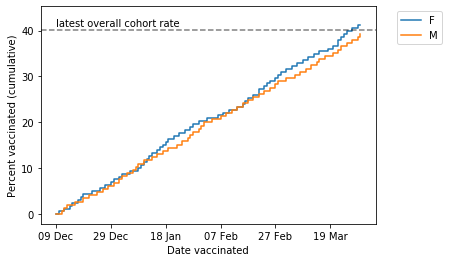

### COVID vaccinations among **80+** population by **ageband 5yr**

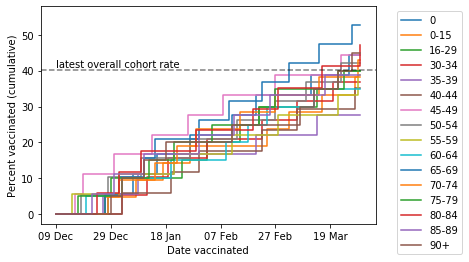

### COVID vaccinations among **80+** population by **ethnicity 6 groups**

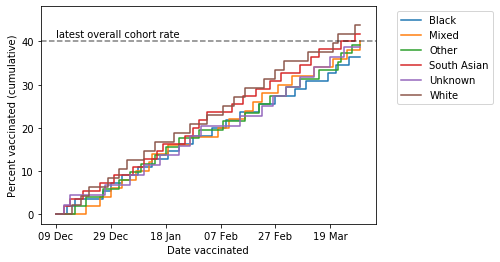

### COVID vaccinations among **80+** population by **imd categories**

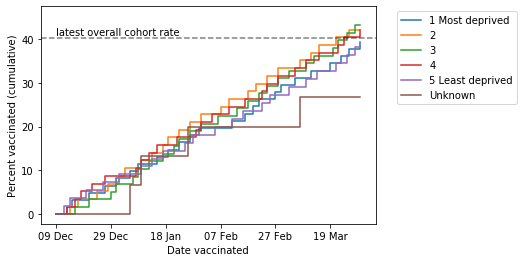

### COVID vaccinations among **80+** population by **bmi**

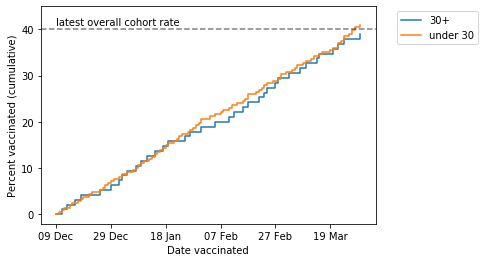

### COVID vaccinations among **80+** population by **chronic cardiac disease**

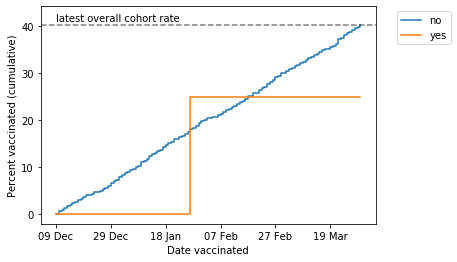

### COVID vaccinations among **80+** population by **current copd**

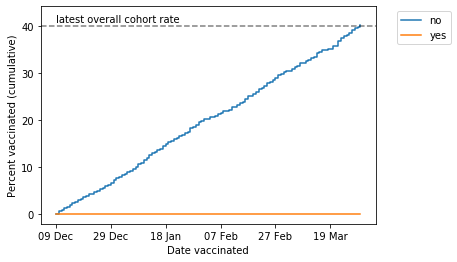

### COVID vaccinations among **80+** population by **dialysis**

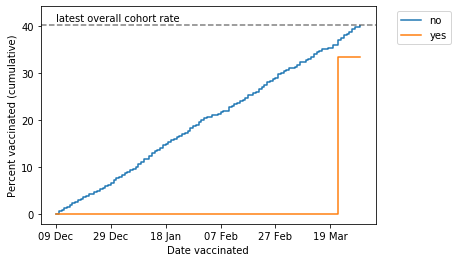

### COVID vaccinations among **80+** population by **dementia**

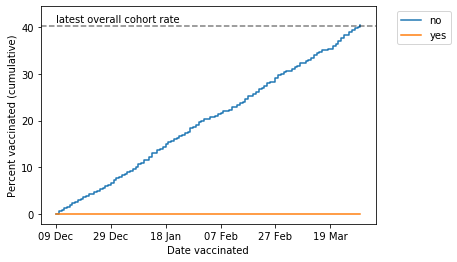

### COVID vaccinations among **80+** population by **psychosis schiz bipolar**

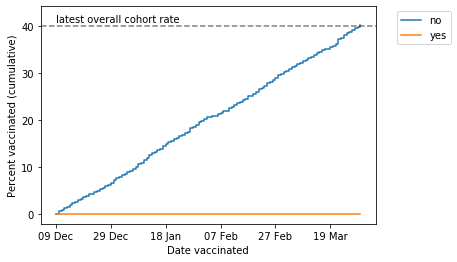

### COVID vaccinations among **80+** population by **LD**

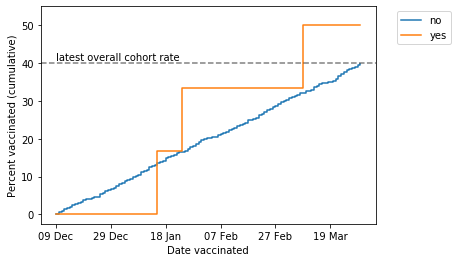

### COVID vaccinations among **80+** population by **ssri**

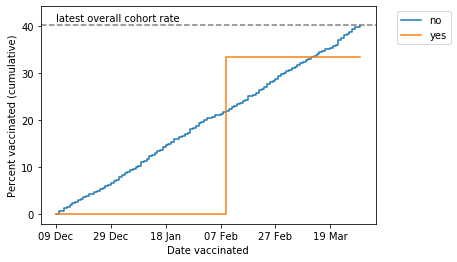

## 
 ## COVID vaccination rollout among **70-79** population up to 30 Mar 2021

### COVID vaccinations among **70-79** population by **sex**

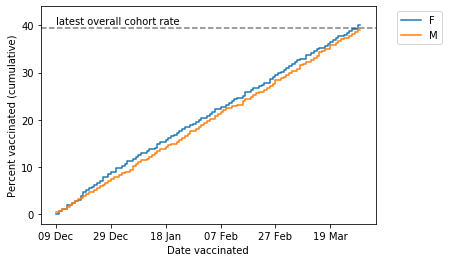

### COVID vaccinations among **70-79** population by **ageband 5yr**

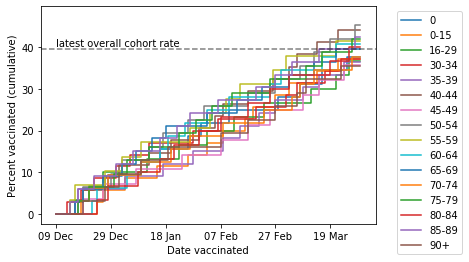

### COVID vaccinations among **70-79** population by **ethnicity 6 groups**

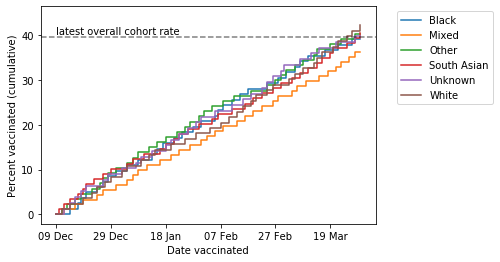

### COVID vaccinations among **70-79** population by **imd categories**

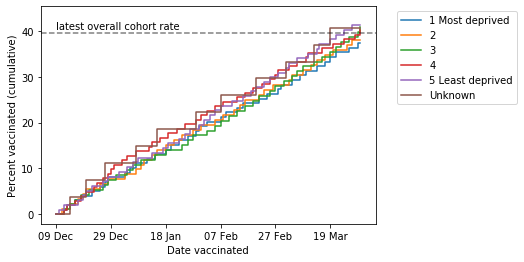

### COVID vaccinations among **70-79** population by **bmi**

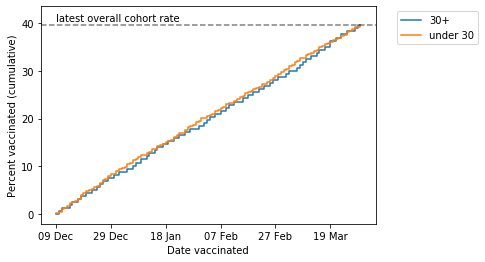

### COVID vaccinations among **70-79** population by **chronic cardiac disease**

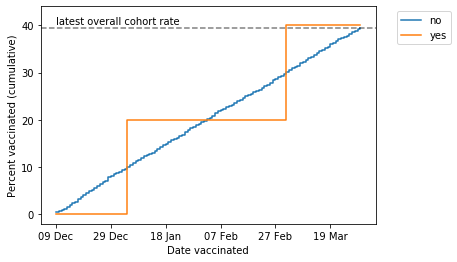

### COVID vaccinations among **70-79** population by **current copd**

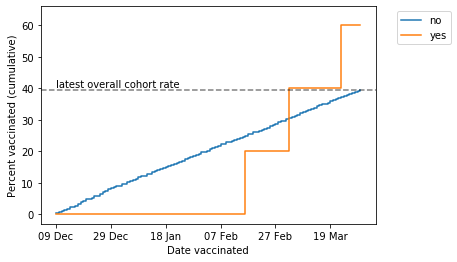

### COVID vaccinations among **70-79** population by **dialysis**

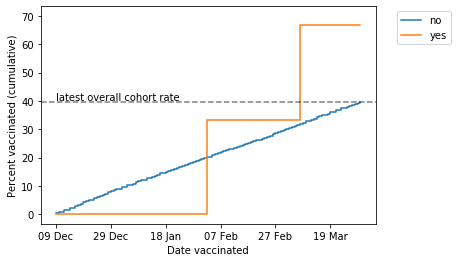

### COVID vaccinations among **70-79** population by **dementia**

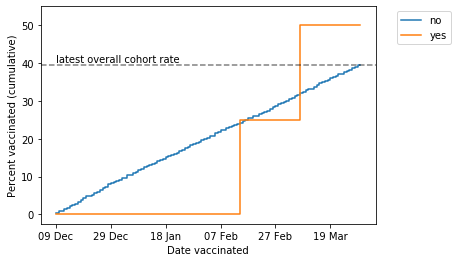

### COVID vaccinations among **70-79** population by **psychosis schiz bipolar**

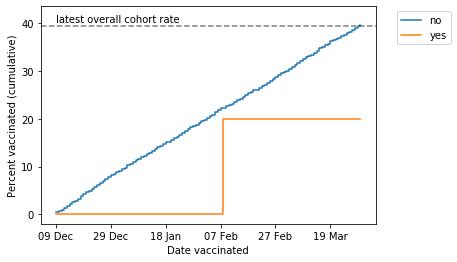

### COVID vaccinations among **70-79** population by **LD**

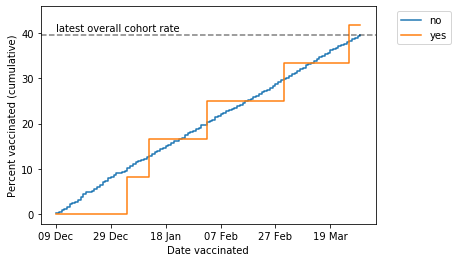

### COVID vaccinations among **70-79** population by **ssri**

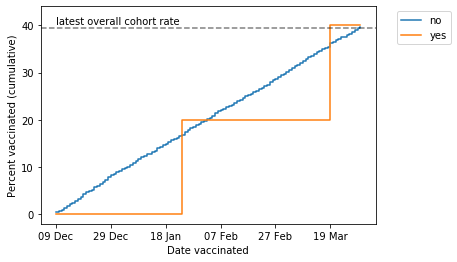

## 
 ## COVID vaccination rollout among **65-69** population up to 30 Mar 2021

### COVID vaccinations among **65-69** population by **sex**

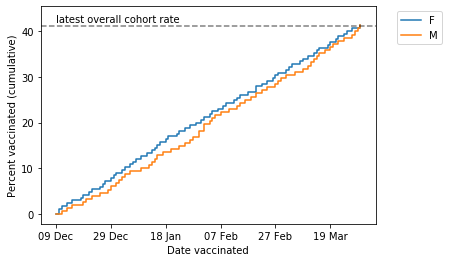

### COVID vaccinations among **65-69** population by **ethnicity 6 groups**

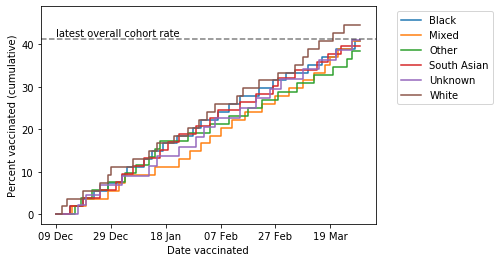

### COVID vaccinations among **65-69** population by **imd categories**

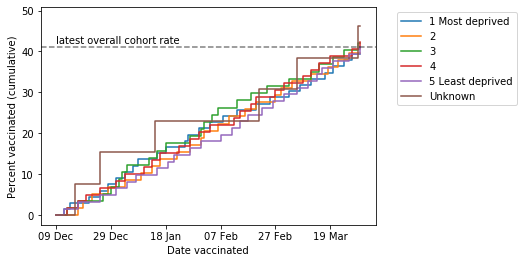

### COVID vaccinations among **65-69** population by **bmi**

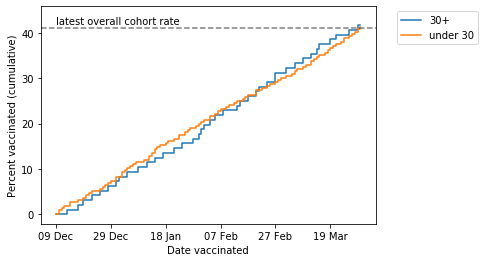

### COVID vaccinations among **65-69** population by **chronic cardiac disease**

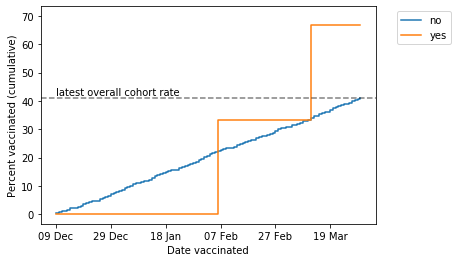

### COVID vaccinations among **65-69** population by **current copd**

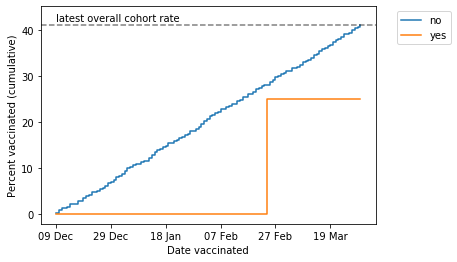

### COVID vaccinations among **65-69** population by **dementia**

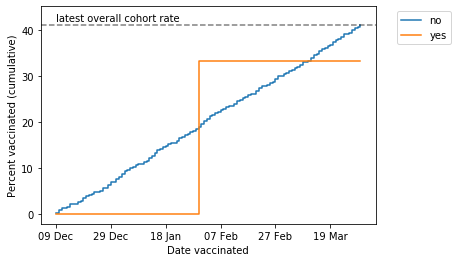

### COVID vaccinations among **65-69** population by **psychosis schiz bipolar**

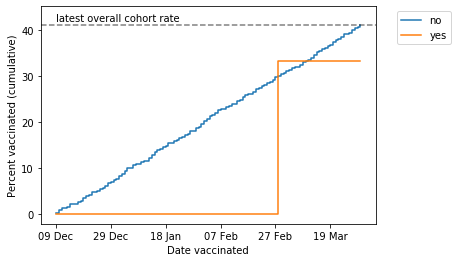

### COVID vaccinations among **65-69** population by **LD**

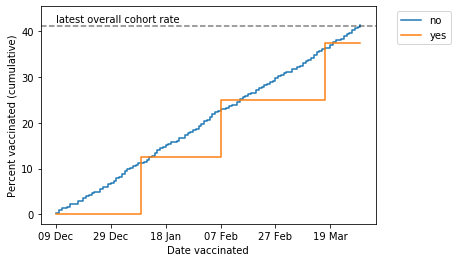

### COVID vaccinations among **65-69** population by **ssri**

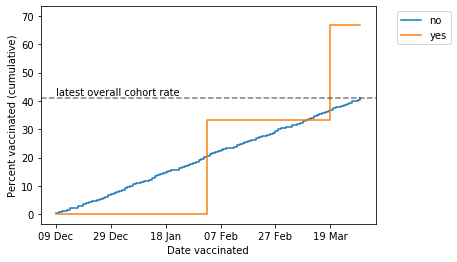

## 
 ## COVID vaccination rollout among **shielding (aged 16-69)** population up to 30 Mar 2021

### COVID vaccinations among **shielding (aged 16-69)** population by **newly shielded since feb 15**

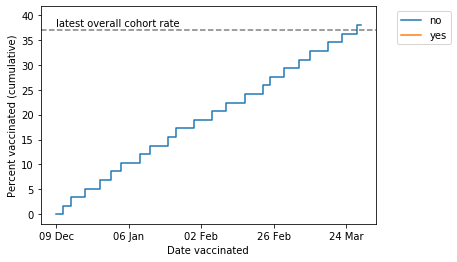

### COVID vaccinations among **shielding (aged 16-69)** population by **sex**

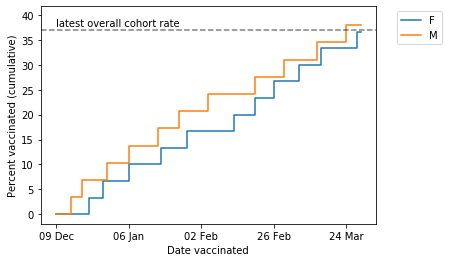

### COVID vaccinations among **shielding (aged 16-69)** population by **ageband**

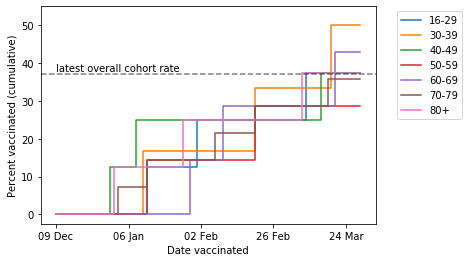

### COVID vaccinations among **shielding (aged 16-69)** population by **ethnicity 6 groups**

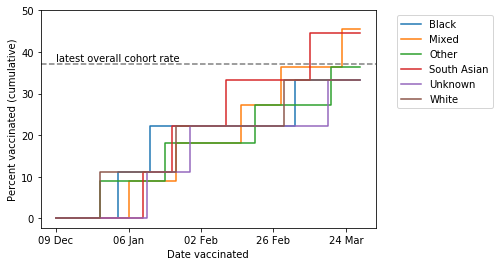

### COVID vaccinations among **shielding (aged 16-69)** population by **imd categories**

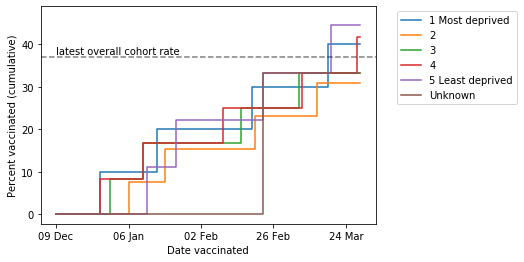

### COVID vaccinations among **shielding (aged 16-69)** population by **LD**

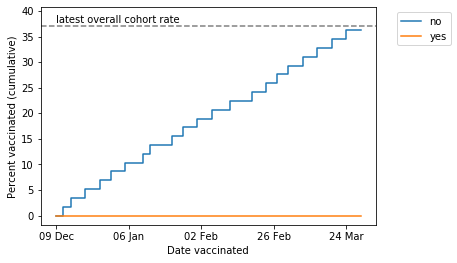

## 
 ## COVID vaccination rollout among **60-64** population up to 30 Mar 2021

### COVID vaccinations among **60-64** population by **sex**

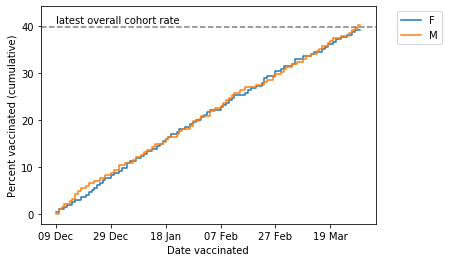

### COVID vaccinations among **60-64** population by **ethnicity 6 groups**

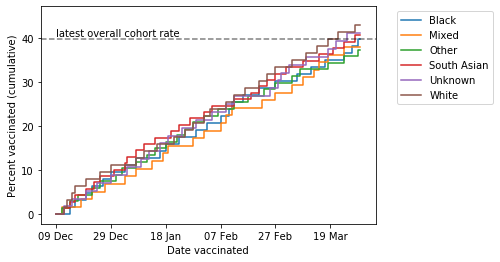

### COVID vaccinations among **60-64** population by **imd categories**

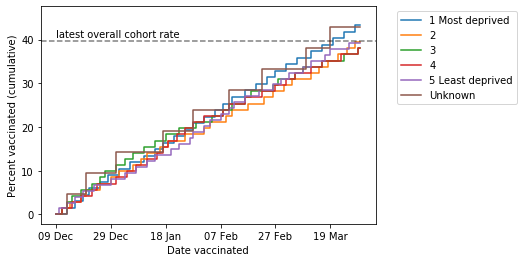

### COVID vaccinations among **60-64** population by **bmi**

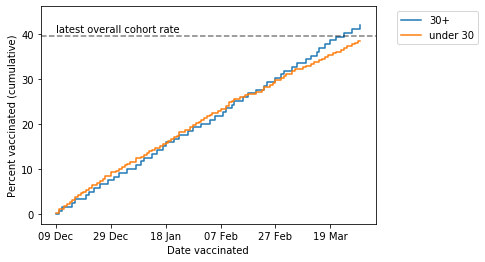

### COVID vaccinations among **60-64** population by **chronic cardiac disease**

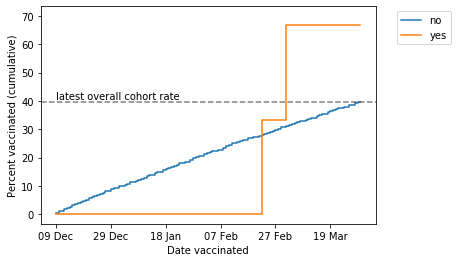

### COVID vaccinations among **60-64** population by **current copd**

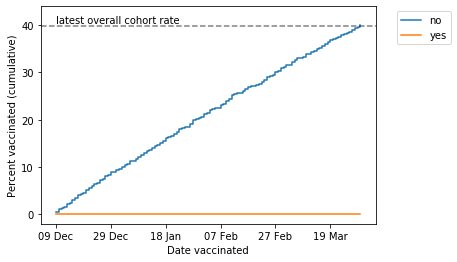

### COVID vaccinations among **60-64** population by **dementia**

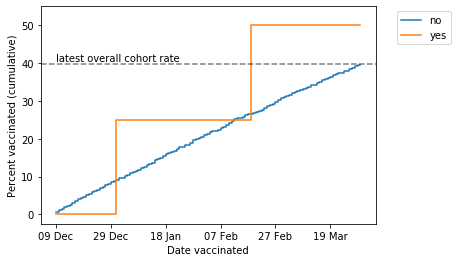

### COVID vaccinations among **60-64** population by **psychosis schiz bipolar**

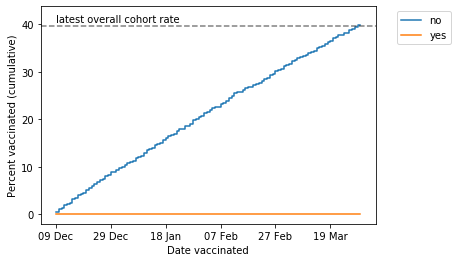

### COVID vaccinations among **60-64** population by **ssri**

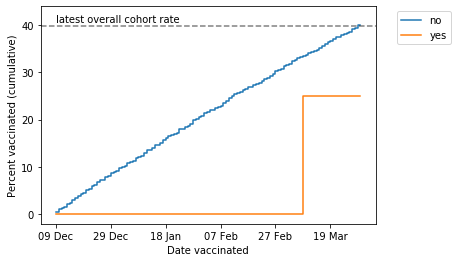

## 
 ## COVID vaccination rollout among **55-59** population up to 30 Mar 2021

### COVID vaccinations among **55-59** population by **sex**

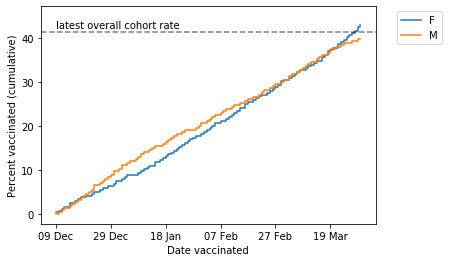

### COVID vaccinations among **55-59** population by **ethnicity 6 groups**

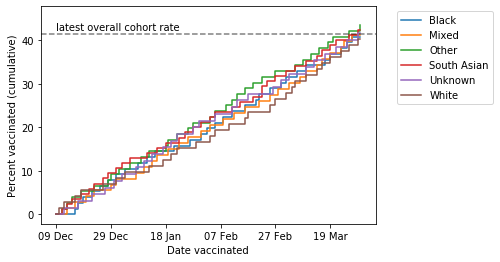

### COVID vaccinations among **55-59** population by **imd categories**

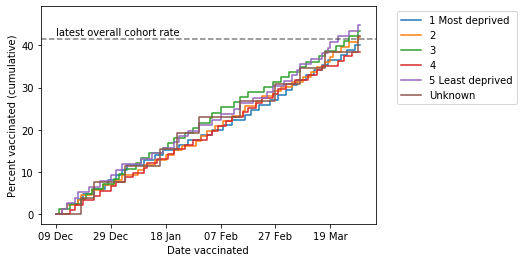

### COVID vaccinations among **55-59** population by **bmi**

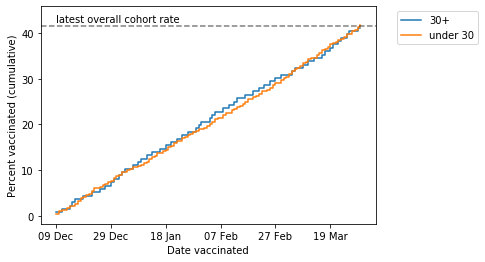

### COVID vaccinations among **55-59** population by **chronic cardiac disease**

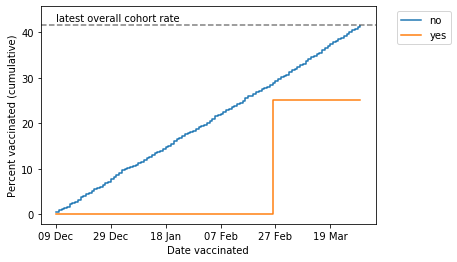

### COVID vaccinations among **55-59** population by **current copd**

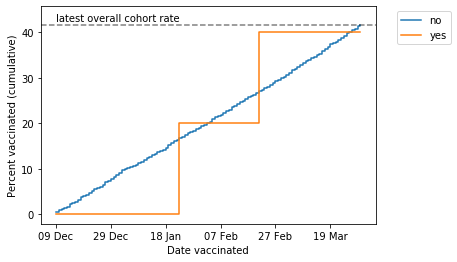

### COVID vaccinations among **55-59** population by **psychosis schiz bipolar**

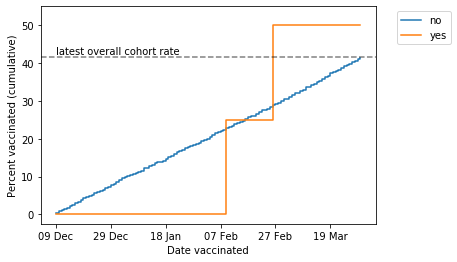

### COVID vaccinations among **55-59** population by **ssri**

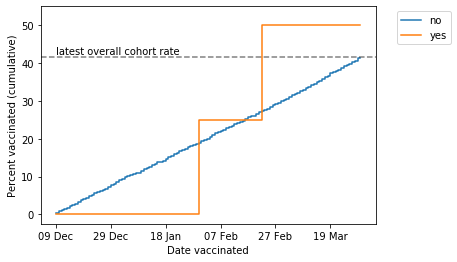

## 
 ## COVID vaccination rollout among **50-54** population up to 30 Mar 2021

### COVID vaccinations among **50-54** population by **sex**

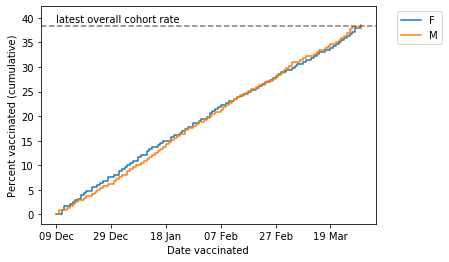

### COVID vaccinations among **50-54** population by **ethnicity 6 groups**

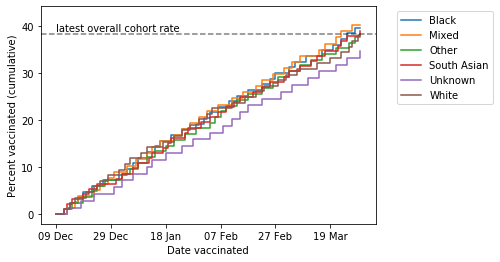

### COVID vaccinations among **50-54** population by **imd categories**

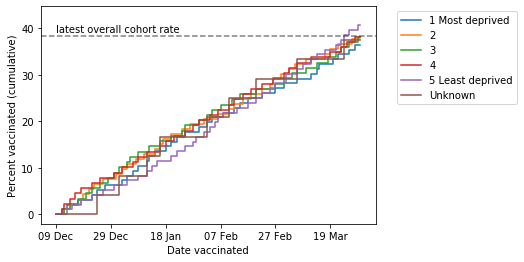

### COVID vaccinations among **50-54** population by **bmi**

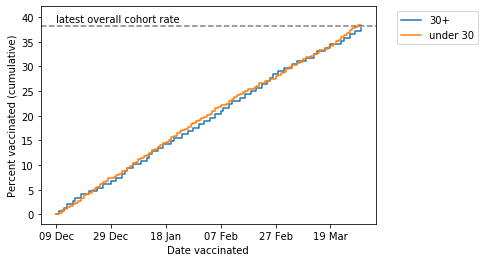

### COVID vaccinations among **50-54** population by **chronic cardiac disease**

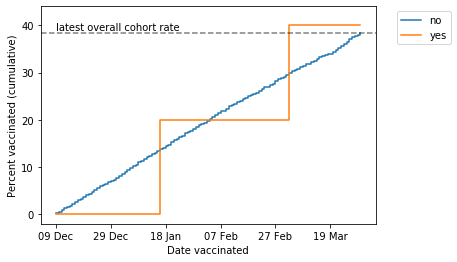

### COVID vaccinations among **50-54** population by **current copd**

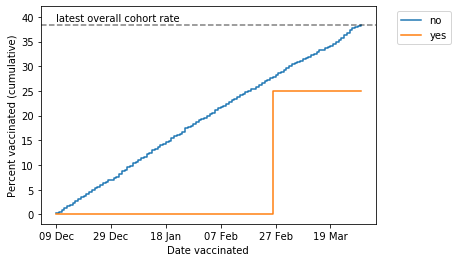

### COVID vaccinations among **50-54** population by **psychosis schiz bipolar**

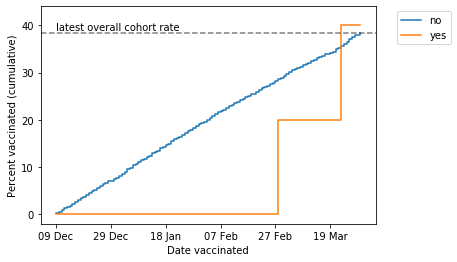

### COVID vaccinations among **50-54** population by **ssri**

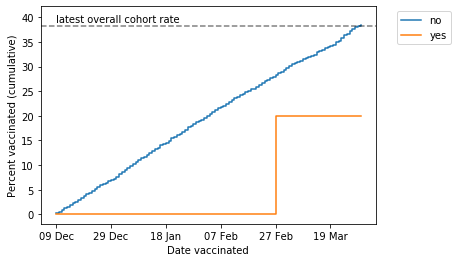

In [33]:
plot_dem_charts(summ_stat_results, df_dict_cum,  formatted_latest_date, pop_subgroups=["80+", "70-79", "65-69","shielding (aged 16-69)", "60-64", "55-59", "50-54"], groups_dict=features_dict,
                groups_to_exclude=["ethnicity_16_groups", "dmards", "chemo_or_radio", "lung_cancer", "cancer_excl_lung_and_haem", "haematological_cancer"],
                savepath=savepath, savepath_figure_csvs=savepath_figure_csvs, suffix=suffix)

## Completeness of ethnicity recording

In [34]:
from data_quality import *

ethnicity_completeness(df=df, groups_of_interest=population_subgroups)


Total **80+** population with ethnicity recorded 1,813 (85.5%)

Total **70-79** population with ethnicity recorded 3,017 (84.5%)

Total **care home** population with ethnicity recorded 1,155 (84.2%)

Total **shielding (aged 16-69)** population with ethnicity recorded 343 (83.1%)

Total **65-69** population with ethnicity recorded 1,876 (85.6%)

Total **LD (aged 16-64)** population with ethnicity recorded 679 (86.6%)

Total **60-64** population with ethnicity recorded 2,240 (85.1%)

Total **55-59** population with ethnicity recorded 2,681 (85.5%)

Total **50-54** population with ethnicity recorded 2,926 (85.8%)

Total **vaccinated 16-49, not in other eligible groups shown** population with ethnicity recorded 25,774 (84.8%)